#**CSE 574 Assignment 3 - Instructions for Using Llama2 on Google Colab**


The Llama 2 is a collection of pretrained and fine-tuned generative text models, ranging from 7 billion to 70 billion parameters, designed for dialogue use cases.  It outperforms open-source chat models on most benchmarks and is on par with popular closed-source models in human evaluations for helpfulness and safety.

The Hugging Face community provides quantized models, which allow us to efficiently and effectively utilize the model on the T4 GPU. It is important to consult reliable sources before using any model.

There are several variations available, but the ones that interest us are based on the GGLM library.

We can see the different variations that Llama-2-13B-GGML has [here](https://huggingface.co/models?search=llama%202%20ggml).



In this case, we will use the model called [Llama-2-13B-chat-GGML](https://huggingface.co/TheBloke/Llama-2-13B-chat-GGML).

##**Step 1: Install and Import All the Required Packages**

In [ ]:
# GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.8 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
    Using cached setuptools-68.2.2-py3-none-any.whl (807 kB)
    Using cached scikit_build-0.17.6-py3-none-any.whl (84 kB)
    Using cached cmake-3.27.7-py2.py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (26.0 MB)
    Using cached ninja-1.11.1.1-py2.py3-none-manylinux1_x86_64.manylinux_2_5_x86_64.whl (307 kB)
    Using cached distro-1.8.0-py3-none-any.whl (20 kB)
    Using cached packaging-23.2-py3-none-any.whl (53 kB)
    Using cached tomli-2.0.1-py3-none-any.whl (12 kB)
    Using cached wheel-0.41.3-py3-none-any.whl (65 kB)
    Creating /tmp/pip-build-env-xh1_ds17/overlay/local/bin
    changing mode of /tmp/pip-build-env-xh1_ds17/overlay/local/bin/ninja to 755
    changing mode

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin" # the model is in bin format

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama


##**Step 2: Download and Load the Model**

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [ ]:
# See the number of layers in GPU
lcpp_llm.params.n_gpu_layers

32

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

##**Step 3: Create a Prompt Template**

In [ ]:
# Correct answer for this question is 27.

question = "The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?"

few_shot_CoT_examples = '''Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. So the answer is 11.
Q: A juggler can juggle 16 balls. Half of the balls are golf balls, and half of the golf balls are blue. How many blue golf balls are there?
A: The juggler can juggle 16 balls. Half of the balls are golf balls. So there are 16 / 2 = 8 golf balls. Half of the golf balls are blue. So there are 8 / 2 = 4 blue golf balls. So the answer is 4.'''

standard_few_shot_examples = '''Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11.
Q: A juggler can juggle 16 balls. Half of the balls are golf balls, and half of the golf balls are blue. How many blue golf balls are there?
A: The answer is 4.'''

prompt_template_standard_zero_shot = f'''
Q: {question}
A: The answer is '''

prompt_template_zero_shot_CoT = f'''
Q: {question}
A: Let's think step by step. '''

prompt_template_standard_few_shot = f'''
{standard_few_shot_examples}
Q: {question}
A: The answer is '''

prompt_template_few_shot_CoT = f'''
{few_shot_CoT_examples}
Q: {question}
A: '''


##**Step 4: Generating the Response**

**(1) Standard Zero-shot**

In [ ]:
response = lcpp_llm(prompt=prompt_template_standard_zero_shot, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)

In [ ]:
print(response["choices"][0]["text"])


Q: The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?
A: The answer is 26. They started with 23 apples, used 20 to make lunch, and then bought 6 more.


**(2) Zero-shot CoT**

In [ ]:
response = lcpp_llm(prompt=prompt_template_zero_shot_CoT, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"])


Q: The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?
A: Let's think step by step. 
First, they used 20 apples to make lunch, so now they have  23 - 20 = 3 apples left.
Next, they bought 6 more apples, so now they have 3 + 6 = 9 apples in total.


**(3) Standard Few-shot**

In [ ]:
response = lcpp_llm(prompt=prompt_template_standard_few_shot, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"])


Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11.
Q: A juggler can juggle 16 balls. Half of the balls are golf balls, and half of the golf balls are blue. How many blue golf balls are there?
A: The answer is 4.
Q: The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?
A: The answer is 18.


**(4) Few-shot CoT**

In [ ]:
response = lcpp_llm(prompt=prompt_template_few_shot_CoT, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"])


Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. So the answer is 11.
Q: A juggler can juggle 16 balls. Half of the balls are golf balls, and half of the golf balls are blue. How many blue golf balls are there?
A: The juggler can juggle 16 balls. Half of the balls are golf balls. So there are 16 / 2 = 8 golf balls. Half of the golf balls are blue. So there are 8 / 2 = 4 blue golf balls. So the answer is 4.
Q: The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?
A: 23 - 20 + 6 = 9. So the answer is 9.


# Test case 1 : Math Word Problem


In [ ]:
# Prompt Template
question = "A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?"

few_shot_CoT_examples = '''Q: A trivia team had 7 members total, but during a game 2 members didn’t show up.
If each member that did show up scored 4 points, how many points were scored total?
A: There were 7 members on the team, but 2 members didn’t show up. That means that there were 5 members that did show up.
Each member that showed up scored 4 points. So if 5 members each scored 4 points, then the total number of points scored would be 5*4=20. So the answer is 20.
Q: Mike made 69 dollars mowing lawns over the summer. If he spent 24 dollars buying new mower blades, how many 5 dollar games could he buy with the money he had left?
A: Mike made $69 from mowing lawns. He spent $24 on new mower blades.
That means he has $45 left. Each game costs $5, so he could buy 9 games. So the answer is 9.'''

standard_few_shot_examples = '''Q: A trivia team had 7 members total, but during a game 2 members didn’t show up.
If each member that did show up scored 4 points, how many points were scored total?
A: The answer is 20.
Q: Mike made 69 dollars mowing lawns over the summer. If he spent 24 dollars buying new mower blades, how many 5 dollar games could he buy with the money he had left?
A: The answer is 9..'''

prompt_template_standard_zero_shot = f'''
Q: {question}
A: The answer is '''

prompt_template_zero_shot_CoT = f'''
Q: {question}
A: Let's think step by step. '''

prompt_template_standard_few_shot = f'''
{standard_few_shot_examples}
Q: {question}
A: The answer is '''

prompt_template_few_shot_CoT = f'''
{few_shot_CoT_examples}
Q: {question}
A: '''

(1) Standard Zero-shot

In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_standard_zero_shot, max_tokens=512, temperature=0.5, top_p=0.95,
                    repeat_penalty=1.2, top_k=150,
                    echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?
A: The answer is 52 customers.


iteration 2

Q: A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?
A: The answer is 52.


iteration 3

Q: A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?
A: The answer is 52.


iteration 4

Q: A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?
A: The answer is 52 customers.


iteration 5

Q: A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?
A: The answer is 52.




(2) Zero-shot CoT

In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_zero_shot_CoT, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?
A: Let's think step by step. 
Firstly, if there are 14 original customers and 3 leave then the number of remaining customers will be:
14 - 3 = 11
Now, if we add another 39 customers to these remaining 11 customers, we get a total of:
11 + 39 = 50 customers.
Therefore, the waiter would have 50 customers in all.


iteration 2

Q: A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?
A: Let's think step by step. 
First, the waiter had 14 customers. 
Then, 3 customers left so now he has 14 - 3 = 11 customers. 
Next, he got another 39 customers so now he has 11 + 39 = 50 customers in total.


iteration 3

Q: A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?
A: Let's think step by step. 
If the waiter original

(3) Standard Few-shot



In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_standard_few_shot, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: A trivia team had 7 members total, but during a game 2 members didn’t show up. 
If each member that did show up scored 4 points, how many points were scored total?
A: The answer is 20.
Q: Mike made 69 dollars mowing lawns over the summer. If he spent 24 dollars buying new mower blades, how many 5 dollar games could he buy with the money he had left?
A: The answer is 9..
Q: A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?
A: The answer is 52.


iteration 2

Q: A trivia team had 7 members total, but during a game 2 members didn’t show up. 
If each member that did show up scored 4 points, how many points were scored total?
A: The answer is 20.
Q: Mike made 69 dollars mowing lawns over the summer. If he spent 24 dollars buying new mower blades, how many 5 dollar games could he buy with the money he had left?
A: The answer is 9..
Q: A waiter had 14 customers to wait on. If 3 customers left and he got

(4) Few-shot CoT

In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_few_shot_CoT, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: A trivia team had 7 members total, but during a game 2 members didn’t show up. 
If each member that did show up scored 4 points, how many points were scored total?
A: There were 7 members on the team, but 2 members didn’t show up. That means that there were 5 members that did show up. 
Each member that showed up scored 4 points. So if 5 members each scored 4 points, then the total number of points scored would be 5*4=20. So the answer is 20.
Q: Mike made 69 dollars mowing lawns over the summer. If he spent 24 dollars buying new mower blades, how many 5 dollar games could he buy with the money he had left?
A: Mike made $69 from mowing lawns. He spent $24 on new mower blades. 
That means he has $45 left. Each game costs $5, so he could buy 9 games. So the answer is 9.
Q: A waiter had 14 customers to wait on. If 3 customers left and he got another 39 customers, how many customers would he have?
A:  The waiter started with 14 customers.  3 customers left, so now there are 1

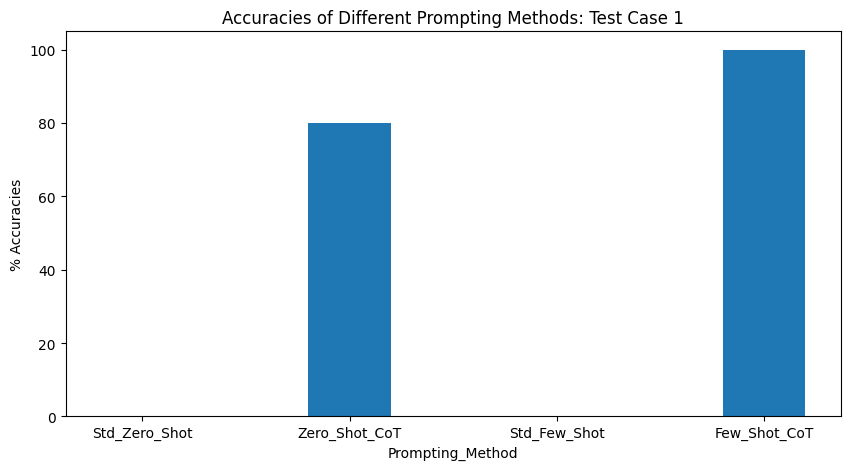

In [ ]:
data = {'Std_Zero_Shot':0, 'Zero_Shot_CoT':80, 'Std_Few_Shot':0, 'Few_Shot_CoT':100}
Prompting_Method = list(data.keys())
Accuracies = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(Prompting_Method, Accuracies,
        width = 0.4)

plt.xlabel("Prompting_Method")
plt.ylabel("% Accuracies")
plt.title("Accuracies of Different Prompting Methods: Test Case 1")
plt.show()

# Test Case 2: Date Understanding Problem

In [ ]:
# Prompt Template
question = "The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?"

few_shot_CoT_examples = '''Q: Jane was born on the last day of Feburary in 2001. Today is her 16-year-old birthday.
What is the date yesterday in MM/DD/YYYY?
A: The last day of February is the 28th, so Jane was born on 02/28/2001. Today is her 16-year old birthday, so today is 02/28/2017.
So yesterday was 02/27/2017. So the answer is 02/27/2017.
Q: It is 4/19/1969 today. What is the date 24 hours later in MM/DD/YYYY?
A: Today is 04/19/1969. 24 hours later is one day after today, which would be 04/20/1969.
So the answer is 04/20/1969.'''

standard_few_shot_examples = '''Q: Jane was born on the last day of Feburary in 2001. Today is her 16-year-old birthday.
What is the date yesterday in MM/DD/YYYY?
A: The answer is 02/27/2017.
Q: It is 4/19/1969 today. What is the date 24 hours later in MM/DD/YYYY?
A: The answer is 04/20/1969.'''

prompt_template_standard_zero_shot = f'''
Q: {question}
A: The answer is '''

prompt_template_zero_shot_CoT = f'''
Q: {question}
A: Let's think step by step. '''

prompt_template_standard_few_shot = f'''
{standard_few_shot_examples}
Q: {question}
A: The answer is '''

prompt_template_few_shot_CoT = f'''
{few_shot_CoT_examples}
Q: {question}
A: '''

(1) Standard Zero-shot

In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_standard_zero_shot, max_tokens=512, temperature=0.5, top_p=0.95,
                    repeat_penalty=1.2, top_k=150,
                    echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: The answer is 05/22/1943.


iteration 2

Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: The answer is 05/22/1943.


iteration 3

Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: The answer is 05/22/1943.


iteration 4

Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: The answer is 05/22/1943 (May 22nd, 1943).


iteration 5

Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: The answer is 05/22/1943 (May 22, 1943).




(2) Zero-shot CoT

In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_zero_shot_CoT, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: Let's think step by step. 
Today is 06/02/1943.
10 days before today would be 05/23/1943 (not 05/22/1943).


iteration 2

Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: Let's think step by step. 
Today is 06/02/1943, so ten days ago would be...  
MM = 05 (May), DD = 22 (22nd of May), YYYY = 1943.
So the date ten days before today in MM/DD/YYYY format is: 05/22/1943


iteration 3

Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: Let's think step by step. 
Today's date is 06/02/1943, so 10 days ago would be...
MM = 05 (May)
DD = 22 (22nd of May)
YYYY = 1943
Therefore, the date 10 days ago in MM/DD/YYYY format is 05/22/1943.


iteration 4

Q: The concert was scheduled to be o

(3) Standard Few-shot


In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_standard_few_shot, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: Jane was born on the last day of Feburary in 2001. Today is her 16-year-old birthday.
What is the date yesterday in MM/DD/YYYY?
A: The answer is 02/27/2017.
Q: It is 4/19/1969 today. What is the date 24 hours later in MM/DD/YYYY?
A: The answer is 04/20/1969.
Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: The answer is 05/21/1943.


iteration 2

Q: Jane was born on the last day of Feburary in 2001. Today is her 16-year-old birthday.
What is the date yesterday in MM/DD/YYYY?
A: The answer is 02/27/2017.
Q: It is 4/19/1969 today. What is the date 24 hours later in MM/DD/YYYY?
A: The answer is 04/20/1969.
Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: The answer is 05/22/1943.


iteration 3

Q: Jane was born on the last day of Feburary in 2001. Today is her 16-year-old birthday.
What is the date yesterd

(4) Few-shot CoT

In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_few_shot_CoT, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: Jane was born on the last day of Feburary in 2001. Today is her 16-year-old birthday.
What is the date yesterday in MM/DD/YYYY?
A: The last day of February is the 28th, so Jane was born on 02/28/2001. Today is her 16-year old birthday, so today is 02/28/2017. 
So yesterday was 02/27/2017. So the answer is 02/27/2017.
Q: It is 4/19/1969 today. What is the date 24 hours later in MM/DD/YYYY?
A: Today is 04/19/1969. 24 hours later is one day after today, which would be 04/20/1969.
So the answer is 04/20/1969.
Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
A: 10 days before today would have been 05/22/1943.
So the answer is 05/22/1943


iteration 2

Q: Jane was born on the last day of Feburary in 2001. Today is her 16-year-old birthday.
What is the date yesterday in MM/DD/YYYY?
A: The last day of February is the 28th, so Jane was born on 02/28/2001. Today is her 16-year old birthday, so today

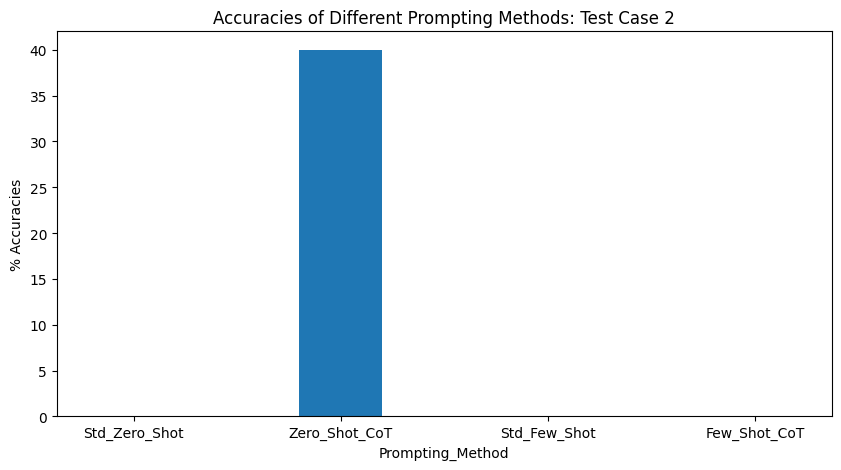

In [ ]:
data = {'Std_Zero_Shot':0, 'Zero_Shot_CoT':40, 'Std_Few_Shot':0, 'Few_Shot_CoT':0}
Prompting_Method = list(data.keys())
Accuracies = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(Prompting_Method, Accuracies,
        width = 0.4)

plt.xlabel("Prompting_Method")
plt.ylabel("% Accuracies")
plt.title("Accuracies of Different Prompting Methods: Test Case 2")
plt.show()

# Test Case 3: Coinflip Problem

In [ ]:
# Prompt Template
question = "A coin is heads up. Ka flips the coin. Sherrie flips the coin. Is the coin still heads up?"

few_shot_CoT_examples = '''Q: A coin is heads up. Jamey flips the coin. Teressa flips the coin. Is the coin still heads up?
A: The coin was flipped by Jamey and Teressa. So the coin was flipped 2 times, which is an even number.
The coin started heads up, so after an even number of flips, it will still be heads up. So the answer is yes.
Q: A coin is heads up. Maybelle flips the coin. Shalonda does not flip the coin. Is the coin still heads up?
A: The coin was flipped by Maybelle. So the coin was flipped 1 time, which is an oddnumber.
The coin started heads up, so after an odd number of flips, it will be tails up. So the answer is no.'''

standard_few_shot_examples = '''Q: A coin is heads up. Jamey flips the coin. Teressa flips the coin. Is the coin still heads
up?
A: The answer is yes.
Q: A coin is heads up. Maybelle flips the coin. Shalonda does not flip the coin. Is the coin
still heads up?
A: The answer is no.'''

prompt_template_standard_zero_shot = f'''
Q: {question}
A: The answer is '''

prompt_template_zero_shot_CoT = f'''
Q: {question}
A: Let's think step by step. '''

prompt_template_standard_few_shot = f'''
{standard_few_shot_examples}
Q: {question}
A: The answer is '''

prompt_template_few_shot_CoT = f'''
{few_shot_CoT_examples}
Q: {question}
A: '''

(1) Standard Zero-shot

In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_standard_zero_shot, max_tokens=512, temperature=0.5, top_p=0.95,
                    repeat_penalty=1.2, top_k=150,
                    echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: A coin is heads up. Ka flips the coin. Sherrie flips the coin. Is the coin still heads up?
A: The answer is 50% chance that it's still heads up and 50% chance that it's tails up.

Q: If a coin lands on its edge, what are the chances that it will land on its head or tail when flipped again?
A: The answer is 0%, because there is no "head" or "tail" side of the coin to land on if it's on its edge.

Q: If a coin lands on its edge, what are the chances that it will stay on its edge when flipped again?
A: The answer is 0%, because coins do not remain on their edges after being flipped. They either land heads up or tails up.


iteration 2

Q: A coin is heads up. Ka flips the coin. Sherrie flips the coin. Is the coin still heads up?
A: The answer is 50% chance that it's still heads up, regardless of who flipped it last. 


iteration 3

Q: A coin is heads up. Ka flips the coin. Sherrie flips the coin. Is the coin still heads up?
A: The answer is 50/50 chance that it's heads or t

(2) Zero-shot CoT

In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_zero_shot_CoT, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: A coin is heads up. Ka flips the coin. Sherrie flips the coin. Is the coin still heads up?
A: Let's think step by step. 1) The coin starts as heads up.  2)Ka flips the coin, so it could be either heads or tails now.  3)Sherrie flips the coin again and gets a result (heads or tails). 4)The final result of the two flips is what matters here: if both Ka and Sherrie got the same result (either both heads or both tails), then the coin stays the same, i.e., it's still heads up. If they got different results, then the coin changes to the opposite side (tails in this case). So, after two flips, the final state of the coin is: 
heads-heads: keeps being heads up  
heads-tails or tails-heads: becomes tails up


iteration 2

Q: A coin is heads up. Ka flips the coin. Sherrie flips the coin. Is the coin still heads up?
A: Let's think step by step.  If the first person, Ka, gets a head, then it stays heads up. But if she gets tails, then it becomes tails up! So we don't know what the 

(3) Standard Few-shot

In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_standard_few_shot, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: A coin is heads up. Jamey flips the coin. Teressa flips the coin. Is the coin still heads
up?
A: The answer is yes.
Q: A coin is heads up. Maybelle flips the coin. Shalonda does not flip the coin. Is the coin
still heads up?
A: The answer is no.
Q: A coin is heads up. Ka flips the coin. Sherrie flips the coin. Is the coin still heads up?
A: The answer is  yes. 


iteration 2

Q: A coin is heads up. Jamey flips the coin. Teressa flips the coin. Is the coin still heads
up?
A: The answer is yes.
Q: A coin is heads up. Maybelle flips the coin. Shalonda does not flip the coin. Is the coin
still heads up?
A: The answer is no.
Q: A coin is heads up. Ka flips the coin. Sherrie flips the coin. Is the coin still heads up?
A: The answer is 50/50 chance.
Q: A coin is heads up. Kaila flips the coin. Jamey flips the coin again. Is the coin still heads up?
A: The answer is yes.


iteration 3

Q: A coin is heads up. Jamey flips the coin. Teressa flips the coin. Is the coin still heads


(4) Few-shot CoT

In [ ]:
answers=[]
for _ in range(5):
  response = lcpp_llm(prompt=prompt_template_few_shot_CoT, max_tokens=512, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)
  answers.append((response["choices"][0]["text"]))

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for i in range(len(answers)):
  print("iteration",i+1)
  print (answers[i])
  print("\n")

iteration 1

Q: A coin is heads up. Jamey flips the coin. Teressa flips the coin. Is the coin still heads up?
A: The coin was flipped by Jamey and Teressa. So the coin was flipped 2 times, which is an even number. 
The coin started heads up, so after an even number of flips, it will still be heads up. So the answer is yes.
Q: A coin is heads up. Maybelle flips the coin. Shalonda does not flip the coin. Is the coin still heads up?
A: The coin was flipped by Maybelle. So the coin was flipped 1 time, which is an oddnumber. 
The coin started heads up, so after an odd number of flips, it will be tails up. So the answer is no.
Q: A coin is heads up. Ka flips the coin. Sherrie flips the coin. Is the coin still heads up?
A:  The coin was flipped by Ka and then by Sherrie. So the coin was flipped twice, which is an even number.
The coin started heads up, so after an even number of flips, it will still be heads up. So the answer is yes.


iteration 2

Q: A coin is heads up. Jamey flips the coin.

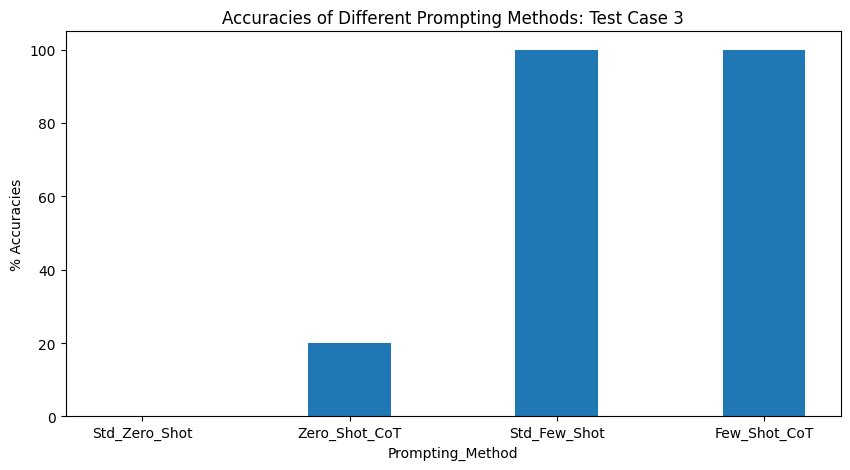

In [ ]:
data = {'Std_Zero_Shot':0, 'Zero_Shot_CoT':20, 'Std_Few_Shot':100, 'Few_Shot_CoT':100}
Prompting_Method = list(data.keys())
Accuracies = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(Prompting_Method, Accuracies,
        width = 0.4)

plt.xlabel("Prompting_Method")
plt.ylabel("% Accuracies")
plt.title("Accuracies of Different Prompting Methods: Test Case 3")
plt.show()